# **Finding Correlations & Trends**

## Dataset Used

I will use various tables in the database (`survey-data.db`) that were created during the `Handling Outliers` section.

### Tables

* __main__ - Main unedited table
* __noOutCompT__ - Table with no outliers in `CompTotal` column
* __noOutCompY__ - Table with no outliers in `ConvertedCompYearly` column

The tables are derived from `clean_survey_data.csv`.

## Objectives 

* Connect to the database using sqlite3
* Find some correlations and trends in the data
* Visualize the correlations and trends

## Download and Import Libraries

In [ ]:
# Run this cell if the libraries are not installed
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install sqlite3

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from numpy import random

## Connect to SQLite3 Database

Since we already created the database, we can easily easily access the tables by creating a connection.

> Note: If the database has not been created, refer to the `Finding_Outliers` notebook and run the cells to create the database and the three tables.

In [2]:
# Create a connection to the SQLite database named 'survey-data.db'
conn = sqlite3.connect('survey-data.db')

### Verify Tables 

In [3]:
# SQL query to select the table names
QUERY = """
SELECT name as Table_Name
FROM sqlite_master
WHERE type = 'table'
"""

# Read the query to a df
pd.read_sql_query(QUERY, conn)

,Table_Name
0,main
1,noOutCompY
2,noOutCompT


## Age Correlation Matrix

### Convert Age Ranges Function

Finding correlations is better when we have numeric values. Since `Age` in our data is categorical, I will create a function to convert the values. Let's use the same function as defined in the `Exploratory_DA` notebook. 

As mentioned before, this won't reflect the survey participants 100% accurately, but it will still be decent since a value can be any value within an age range. 

In [5]:
# Function provide a random age between the age ranges
# Ages below 18 and above 65 would have a reasonable range
def randAge(data):
    if '18-24' in data:
        return random.randint(18, 25)
    elif '25-34' in data:
        return random.randint(25, 35)
    elif '35-44' in data:
        return random.randint(35, 45)
    elif '45-54' in data:
        return random.randint(45, 55)
    elif '55-64' in data:
        return random.randint(55, 65)
    elif '65' in data:
        return random.randint(65, 80)
    elif 'Under' in data:
        return random.randint(13, 18)
    else:
        return None

### Creating the Matrix

In [6]:
# Selects the target columns from main table
QUERY = """
SELECT Age, YearsCode, YearsCodePro, WorkExp
FROM main
"""

# Read the query to a df
age_corr = pd.read_sql(QUERY, conn)

In [7]:
# Create a new column to store the ages
# Apply the function to the Age column
age_corr['Age_Num'] = age_corr['Age'].apply(randAge)
age_corr[['Age', 'Age_Num']].head()

,Age,Age_Num
0,35-44 years old,35.0
1,45-54 years old,46.0
2,18-24 years old,20.0
3,18-24 years old,18.0
4,Under 18 years old,16.0


In [ ]:
# Create a table to show the correlations 
age_corr_matrix = age_corr[['Age_Num', 'YearsCode', 'YearsCodePro', 'WorkExp']].corr()
age_corr_matrix

,Age_Num,YearsCode,YearsCodePro,WorkExp
Age_Num,1.000000,0.771044,0.695069,0.817848
YearsCode,0.771044,1.000000,0.834460,0.866637
YearsCodePro,0.695069,0.834460,1.000000,0.911976
WorkExp,0.817848,0.866637,0.911976,1.000000


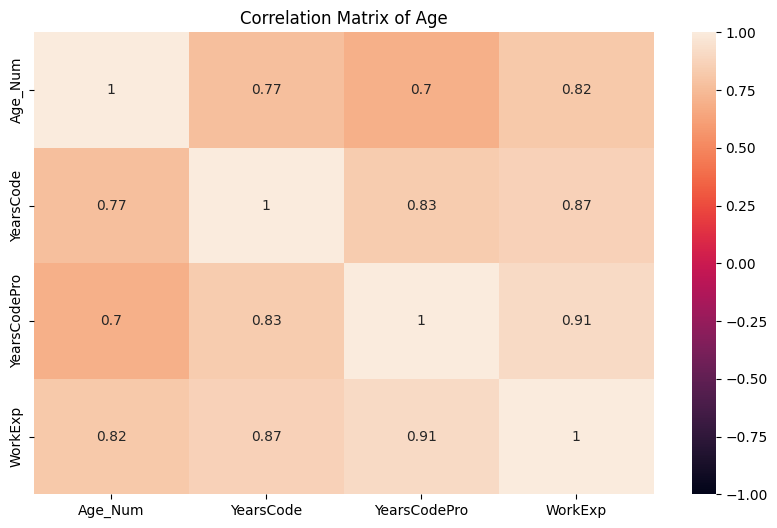

In [15]:
# Create a heatmap to show the correlation matrix
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(age_corr_matrix, annot=True, vmin=-1, vmax=1,ax = ax)
ax.set_title("Correlation Matrix of Age")
plt.show()

The `corr()` function uses the Pearson correlation coefficient to determine the correlation.

* 1 indicates perfect positive linear correlation
* 0 indicates no linear correlation
* -1 indicates perfect negative linear correlation

Based on the correlation matrix from the heatmap, it seems like age has a positive correlation with the other columns. Every age Pearson correlation coefficient value is 7.0 or higher, which pretty close to 1. Furthermore, all of the colors on the heatmap are relatively pretty light so that indicates that every variable are positively correlated with each other. 

## Age and Years Coding Professionally

Let's use a scatter plot to visualize the relationship between age (`Age_Num`) and years coding professionally (`YearsCodePro`).

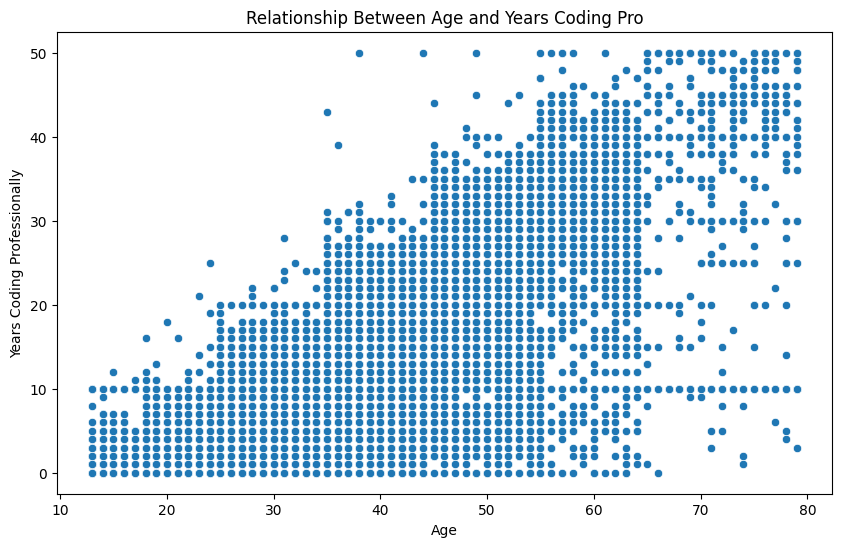

In [18]:
# Plot the scatter plot
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(age_corr, x='Age_Num', y='YearsCodePro', ax=ax)
ax.set_title("Relationship Between Age and Years Coding Pro")
ax.set_ylabel("Years Coding Professionally")
ax.set_xlabel("Age")
plt.show()

We can generally see a positive relationship in this scatter plot. There are some interesting outliers since many values don't make sense for some of the points. This could indicate a mistake in the participants' input or a data error. Regardless, it still indicates a positive correlation even though it might not be the strongest. 

## Age and Work Experience

Let's visualize the relationship of age (`Age_Num`) and another variable that has a higher correlation. Since work experience (`WorkExp`) has the highest correlation value, let's visualize with that. 

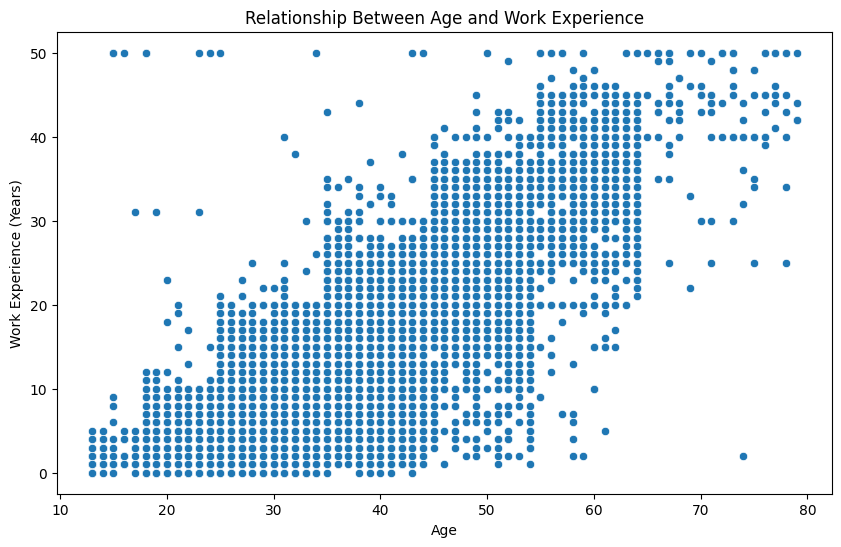

In [31]:
# Plot the scatter plot
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(age_corr, x='Age_Num', y='WorkExp', ax=ax)
ax.set_title("Relationship Between Age and Work Experience")
ax.set_ylabel("Work Experience (Years)")
ax.set_xlabel("Age")
plt.show()

This plot shows a better positive correlation than the previous. As age increases, the years of work experience will tend to increase. Once again, there are also some weird values that makes no sense. There are some points with 50 years of work experience but the age is less than 50. 

## Years Coding Pro and Work Experience

Let's visualize the relationship of years coding pro (`YearsCodePro`) and work experience (`WorkExp`) using a scatter plot.

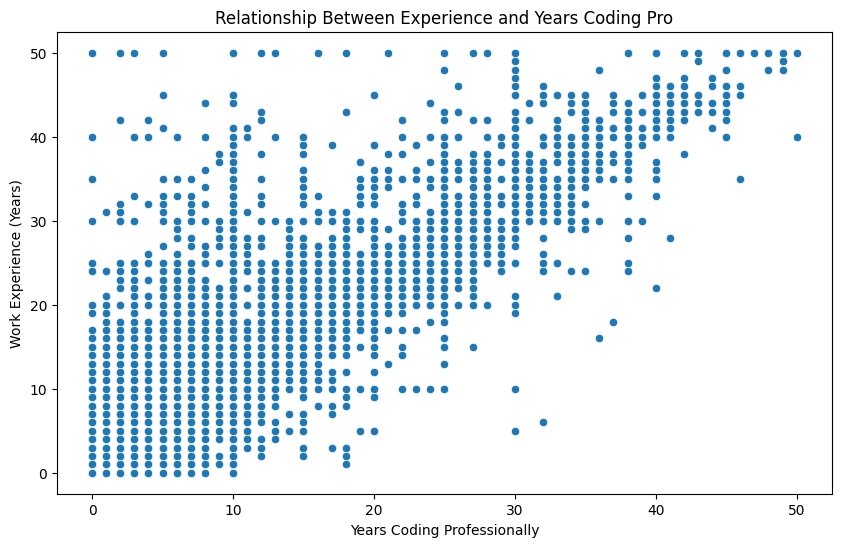

In [24]:
# Plot the scatter plot
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(age_corr, x='YearsCodePro', y='WorkExp', ax=ax)
ax.set_title("Relationship Between Experience and Years Coding Pro")
ax.set_ylabel("Work Experience (Years)")
ax.set_xlabel("Years Coding Professionally")
plt.show()

The positive correlation is very visible in this scatter plot. It makes sense since more years of coding professionally would indicate that you would have more work experience. 

## Trends in Compensation by Age

Let's now find trends of median total compensation (`CompTotal`) by age (`Age`). Line plots are great for visualizing trends. 

In [ ]:
# Select the target columns from the no outliers table
QUERY = """
SELECT Age, CompTotal
FROM noOutCompT
"""

# Read the query
df_age_compT = pd.read_sql(QUERY, conn)

In [41]:
# Assign an age for each age group using the randAge function
df_age_compT['Age_Num'] = df_age_compT['Age'].apply(randAge)
df_age_compT[['Age', 'Age_Num']] 

,Age,Age_Num
0,25-34 years old,29.0
1,35-44 years old,44.0
2,35-44 years old,35.0
3,25-34 years old,34.0
4,35-44 years old,39.0
...,...,...
27602,18-24 years old,19.0
27603,25-34 years old,25.0
27604,25-34 years old,26.0
27605,35-44 years old,42.0


In [45]:
# Group each age and calculate the median total compensation
age_compT_group = df_age_compT.groupby('Age_Num')['CompTotal'].median().reset_index()

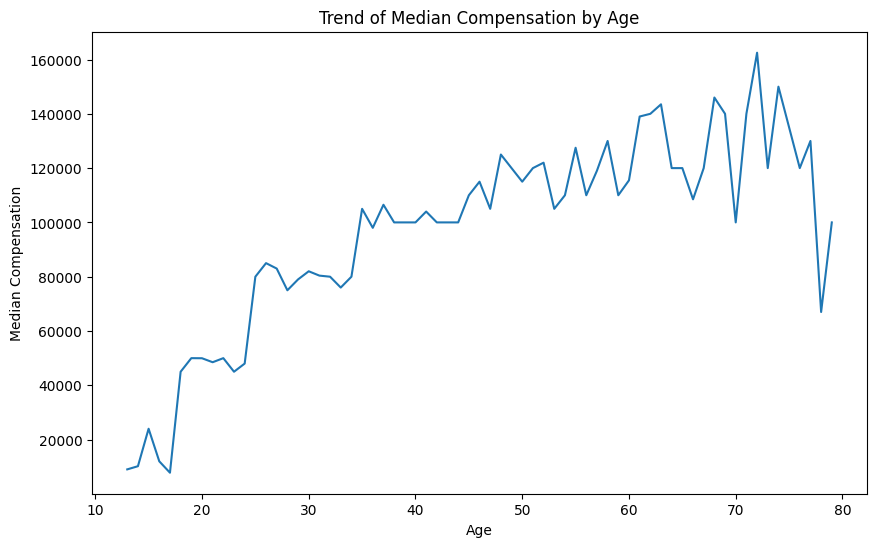

In [46]:
# Plot the line plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(age_compT_group['Age_Num'], age_compT_group['CompTotal'])
ax.set_title("Trend of Median Compensation by Age")
ax.set_xlabel("Age")
ax.set_ylabel("Median Compensation")
plt.show()

There appears to be a positive trend in this line plot. The median total compensation generally increases as age increase. There is a drop in the later years which could indicate compensation dropping during retirement years. 

## Trends in Work Experience by Yearly Compensation

Let's use a line plot to visualize trends in work experience (`WorkExp`) and the median yearly compensation (`ConvertCompYearly`)

In [39]:
# Select column from the correct table
QUERY = """
SELECT ConvertedCompYearly, WorkExp
FROM noOutCompY
WHERE WorkExp IS NOT NULL
"""

# Read to a df
df_exp_compY = pd.read_sql(QUERY, conn)

# Group each year and calculate the median age
exp_compY_group = df_exp_compY.groupby('WorkExp')['ConvertedCompYearly'].median().reset_index()

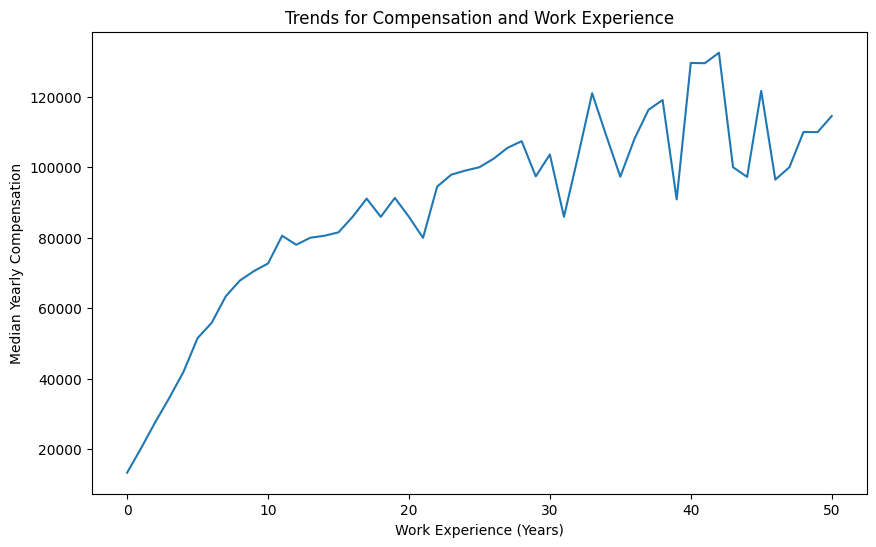

In [40]:
# Plot the line plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(exp_compY_group['WorkExp'], exp_compY_group['ConvertedCompYearly'])
ax.set_title("Trends for Compensation and Work Experience")
ax.set_ylabel("Median Yearly Compensation")
ax.set_xlabel("Work Experience (Years)")
plt.show()

There seems to be a upward positive trend in this line plot. The median yearly compensation generally increases as the years of work experience increases

## Close the Connection

In [47]:
# Remember to close the connection with the database at the end
conn.close()